# Libraries

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf   # Pyfits is depracated
import astropy.constants as ct
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
import os
import scipy.interpolate as sci
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# FIT or FITS file's

In [2]:
sed_example = '../../GAMAII_SPEC/WHAN_NA_UVUP/G09_Y1_CX1_374_modified.fit'

In [3]:
sed = pf.open(sed_example)

In [4]:
header = sed[0].header

In [5]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4944 / length of data axis 1                          
NAXIS2  =                    5 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                   1. / True_value = BSCALE * FITS_value + BZERO       
BZERO   =                   0. / True_value = BSCALE * FITS_value + BZERO       
DATE    = '2015-03-24T14:06:21' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'GAMA    '           / Source of the data                             
OBSERVAT= 'SSO     '        

In [6]:
flux_all     = pf.getdata(sed_example)[0, 3:-3]
flux_err_all = pf.getdata(sed_example)[1, 3:-3]

In [7]:
idx_clean = np.where(np.logical_not(np.isnan(flux_all)))

In [8]:
flux     = flux_all[idx_clean]
flux_err = flux_err_all[idx_clean]

In [9]:
wl_i    = header['WMIN']
wl_step = header['CD1_1']
wl      = np.arange(flux.size)*wl_step + wl_i

In [10]:
redshift = header['Z']

In [11]:
# %matplotlib notebook

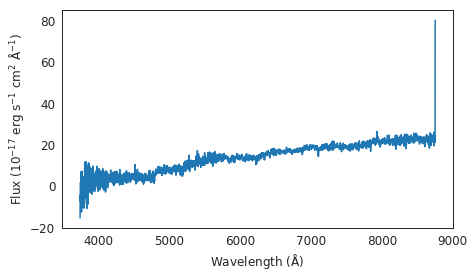

In [12]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(7,4))
plt.plot(wl,flux,'-')
plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
plt.ylabel("Flux (10$^{-17}$ erg s$^{-1}$ cm$^2$ $\mathrm{\AA^{-1}}$)", fontsize=12)
plt.tick_params('both', labelsize=12)
plt.show()

# pPXF config

### Getting the Libraries' path -- those that already came with ppxf

In [13]:
wl_range_index = (wl>3540) & (wl<7409)              # Limiting the range of wl given the library -- in this case MILES

In [14]:
ppxf_dir = os.path.dirname(os.path.realpath(ppxf_module.__file__))

In [15]:
ppxf_dir

'/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ppxf'

In [16]:
flux_pp = flux[wl_range_index]
wl_pp   = wl[wl_range_index]

In [17]:
print (flux_pp)

[-15.374364   -4.797919   -4.4835305 ...  20.24269    20.094873
  19.964918 ]


In [18]:
print(ct.c)

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2014


In [19]:
print(ct.c.to('km/s'))

299792.458 km / s


In [20]:
light_kms = float(str(ct.c.to('km/s')).split(' ')[0])     # selecting the numerical values only

In [21]:
vel_scale = light_kms*np.log(wl_pp[1]/wl_pp[0])    # velocity scale - Eq.8 Capellari 2017

In [22]:
fwhm_gama = 2.                                     # MUST BE CHECKED!!!!! This is just a temporary value!!!

In [23]:
# TODO 
# check the following information for GAMA:
# 1) Are the spectra corrected by the air?  -- Do I need to correct them before runing ppxf?
# 2) What is the FWHM (espectral resolution) of GAMA spectra? - IDEM
# 3) Do we need gas templates?

In [24]:
miles_templates = ppxf_dir+'/miles_models/Mun1.30*.fits'

In [35]:
miles = lib.miles(miles_templates, vel_scale, fwhm_gama)

In [26]:
regularization_dimensions = miles.templates.shape[1:]
stellar_templates         = miles.templates.reshape(miles.templates.shape[0], -1)
print (stellar_templates.shape)

(2664, 150)


In [27]:
regularization_err = 0.013                        # Desired regularization error

In [28]:
wl_range = np.array([np.min(wl_pp), np.max(wl_pp)])/(1 + redshift)

In [29]:
dv    = light_kms*(miles.log_lam_temp[0] - np.log(wl_pp[0]))  # eq.(8) of Cappellari (2017)
vel   = light_kms*np.log(1 + redshift)                        # eq.(8) of Cappellari (2017)
start = [vel, 180.]                                           # (km/s), starting guess for [V, sigma]

In [30]:
# TODO: REBIN ? See error below.

In [31]:
new_shape          = stellar_templates[:,0].shape
rebinning_function = sci.interp1d(wl_pp, flux_pp)
wl_pp_rebin        = np.linspace(start=wl_pp.min(), stop=wl_pp.max(), num=int(new_shape[0]))
flux_pp_rebin      = rebinning_function(wl_pp_rebin)

In [32]:
galaxy  = flux_pp_rebin/np.median(flux_pp_rebin)   # Normalize spectrum to avoid numerical issues

In [33]:
noise = np.full_like(galaxy, 0.01635)              # Assume constant noise per pixel here
# MUST BE CHECKED!!!!! This is just a temporary value!!!

In [37]:
%matplotlib notebook

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     58976       583    -0.080    -0.013
chi2/DOF: 29.05
method = capfit ; Jac calls: 7 ; Func calls: 40 ; Status: 2
Nonzero Templates:  1  /  150


<IPython.core.display.Javascript object>


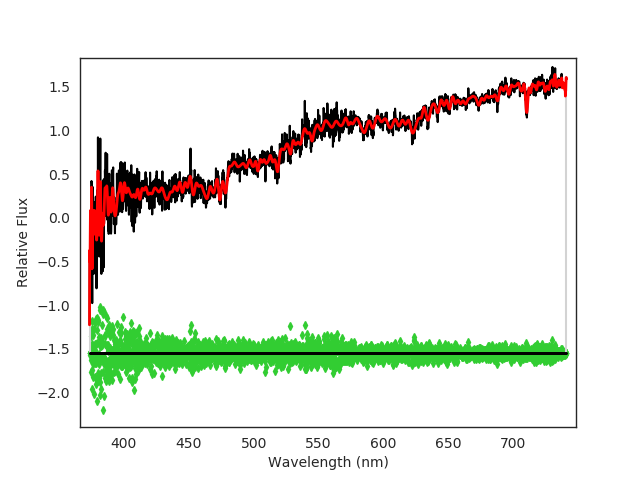

In [85]:
pp = ppxf(templates=stellar_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start, plot=True, 
          lam=wl_pp_rebin, moments=4, degree=250)

In [86]:
pp.bestfit

array([-1.22329505, -0.37344859, -0.5042784 , ...,  1.59928294,
        1.60279836,  1.58855085])

In [87]:
pp.chi2

29.05012921059821

In [88]:
pp.bias

0

In [89]:
pp.clean

False

In [90]:
pp.apoly

array([-1.57303319, -0.7229255 , -0.8534935 , ...,  1.23876014,
        1.24252058,  1.22852125])

In [91]:
pp.component

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
pp.sol

array([ 5.89764502e+04,  5.83136952e+02, -8.03152732e-02, -1.33812228e-02])

In [93]:
pp.ftol

0.0001

In [94]:
pp??

In [102]:
plt.subplot(2,1,1)
plt.plot(wl_pp_rebin, pp.galaxy, '-', linewidth=1., label="Spectrum")
plt.plot(wl_pp_rebin, pp.bestfit, '-', linewidth=1., label="Best Fit")
plt.legend(loc='best')
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Norm. flux")
plt.subplot(2,1,2)
plt.plot(wl_pp_rebin, (galaxy-pp.bestfit), '.', linewidth=1., label="Residues", alpha=0.8)
plt.axhline(y=0, c='black')
plt.legend(loc='best')
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Residues")
plt.show()

<IPython.core.display.Javascript object>